In [39]:
import wandb
import subprocess
import os
import torch
import matplotlib.pyplot as plt
import mixed_BVP as bvp

# Hyperparameter optimization with Weights and Biases

In [20]:
# Initialize the wandb sweep with the possible values for the hyperparameters
sweep_dict = {
    'net_type': {'values': ['Unet','USnet']},
    'n_layers': { 'max': 10,'min': 2},
    'size_layers': {'values': [50,75,100]},
    'activation': {'values': ['tanh','sigmoid']},
    'loss_type': {'values':  ['pde']},
    'num_samples': {'values': [25,50,75,100]},
    'bc_type': {'value': 'hard'},
    'train_distribution': {'value': 'Hammersley'},
    'optimizers': {'value': ["adam"]},
    'learning_rates': {'value': [1e-3]},
    'iterations': {'value': [300]}
}
#Bayesian updating hyper-optimization to minimize accuracy metric
sweep_config = {
    'method': 'bayes',
    'parameters': sweep_dict,
    'metric': {
        'name': 'accuracy_metric',
        'goal': 'minimize'   
    },
    'name': 'sweep-1',
    'program': 'mixed_BVP.py'
    }

project_name = 'HPO-PINN-CM'
sweep_id = wandb.sweep(sweep_config, project=project_name)

Create sweep with ID: 4sh96xkg
Sweep URL: https://wandb.ai/damien-bonnet/HPO-PINN-CM/sweeps/4sh96xkg


In [21]:
wandb_profile = "damien-bonnet"
project_name = 'HPO-PINN-CM'

# sweep_id = "4sh96xkg"
count = 1

#command line to run agent from the terminal
cmd_line = f"wandb agent {wandb_profile}/{project_name}/{sweep_id} --count {count}"
print(cmd_line)

wandb agent damien-bonnet/HPO-PINN-CM/4sh96xkg --count 1


In [50]:
#run the agent in the notebook

wandb_train = bvp.wandb_train
wandb.agent(sweep_id, bvp.wandb_train, count=count)

# Load saved model and plot solution

In [51]:
import yaml
import glob
  
def load_config(path):  
    with open(path, 'r') as file:
        config = yaml.load(file, Loader=yaml.FullLoader)
        config.pop('wandb_version')
        config.pop('_wandb')
        for key, val in config.items():
            config[key] = val["value"]
    return config

def path_from_id(run_id):
    config_path = os.path.join('wandb',f"*-{run_id}","files")
    return glob.glob(config_path)[0]

def load_model(run_id,device=None):
    config_path = os.path.join(path_from_id(run_id),"config.yaml")
    model_path = os.path.join(path_from_id(run_id),"model-*.pt")
    model_path = glob.glob(model_path)[-1]
    config = load_config(config_path)
    config["num_domain"] = config["num_samples"]**2
    config["num_boundary"] = config["num_samples"]    
    model = bvp.model_setup(bvp.geom,config)

    model.compile('adam', lr=0.001)
    model.restore(model_path,device=device)    
    return model, config

Compiling model...
'compile' took 0.000318 s



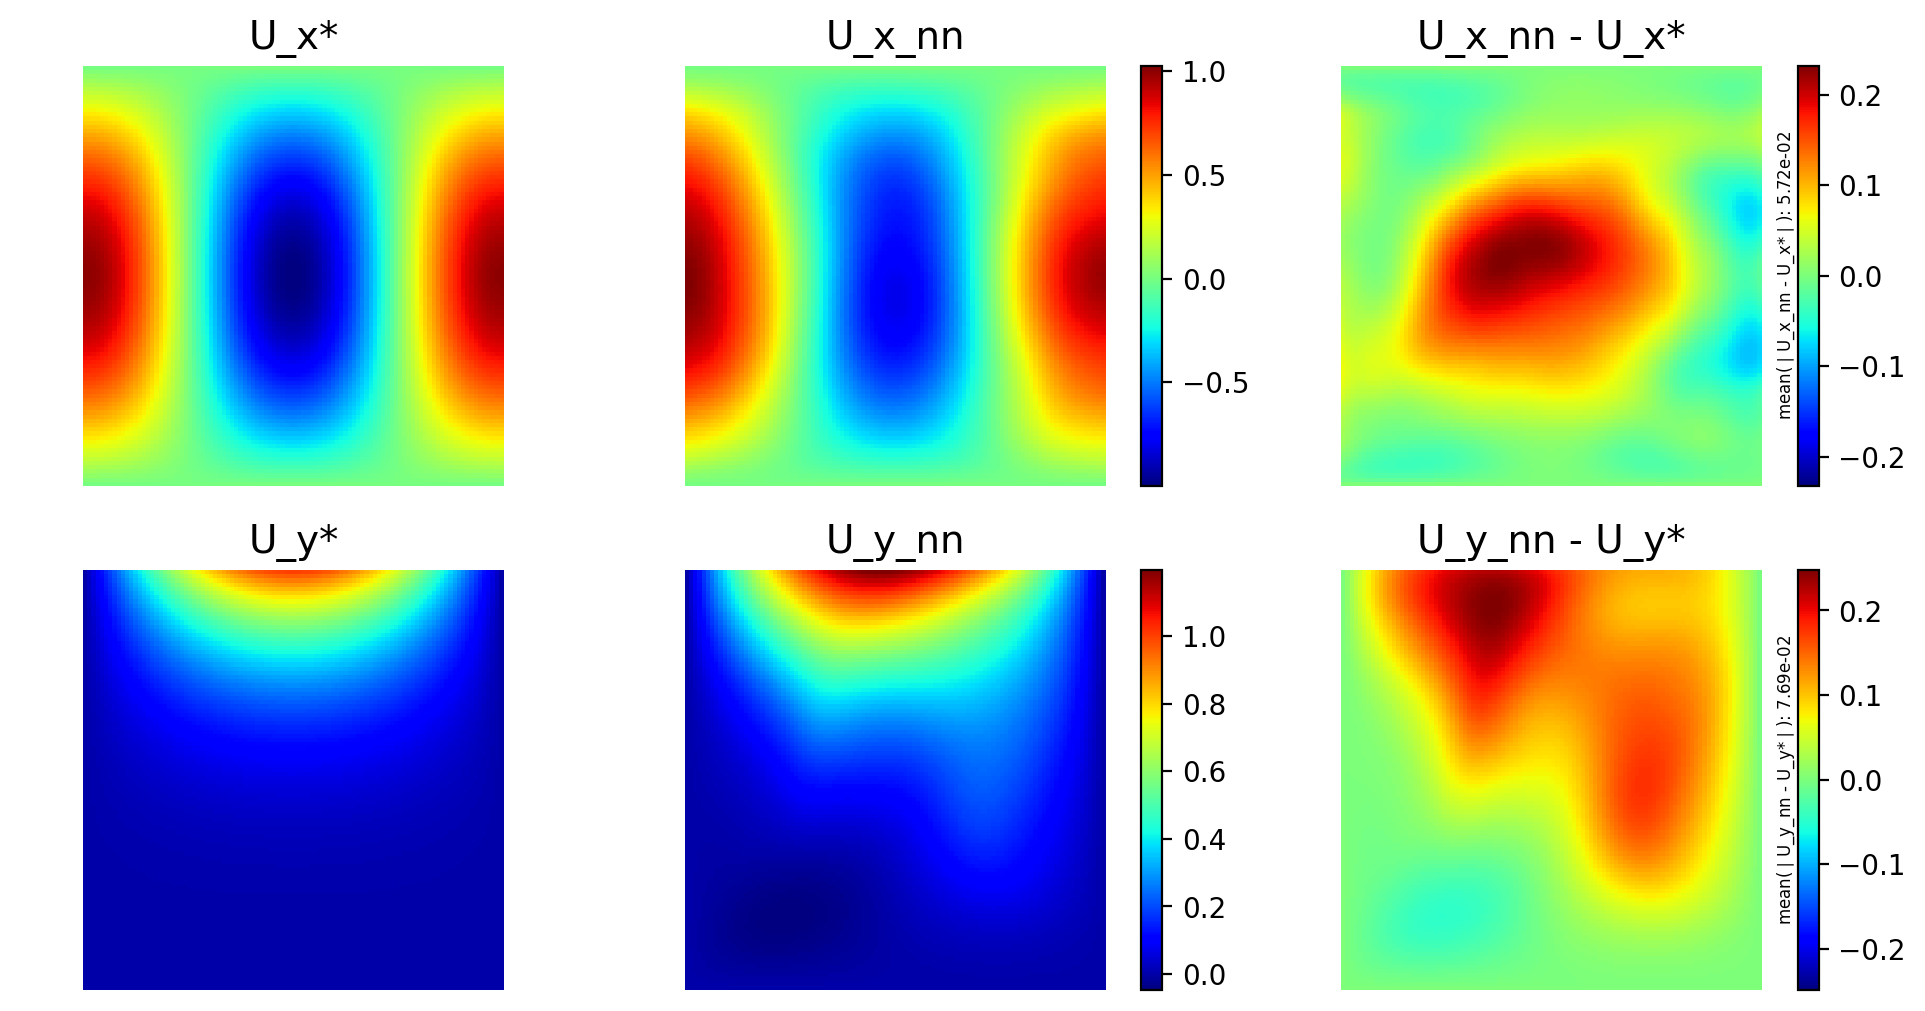

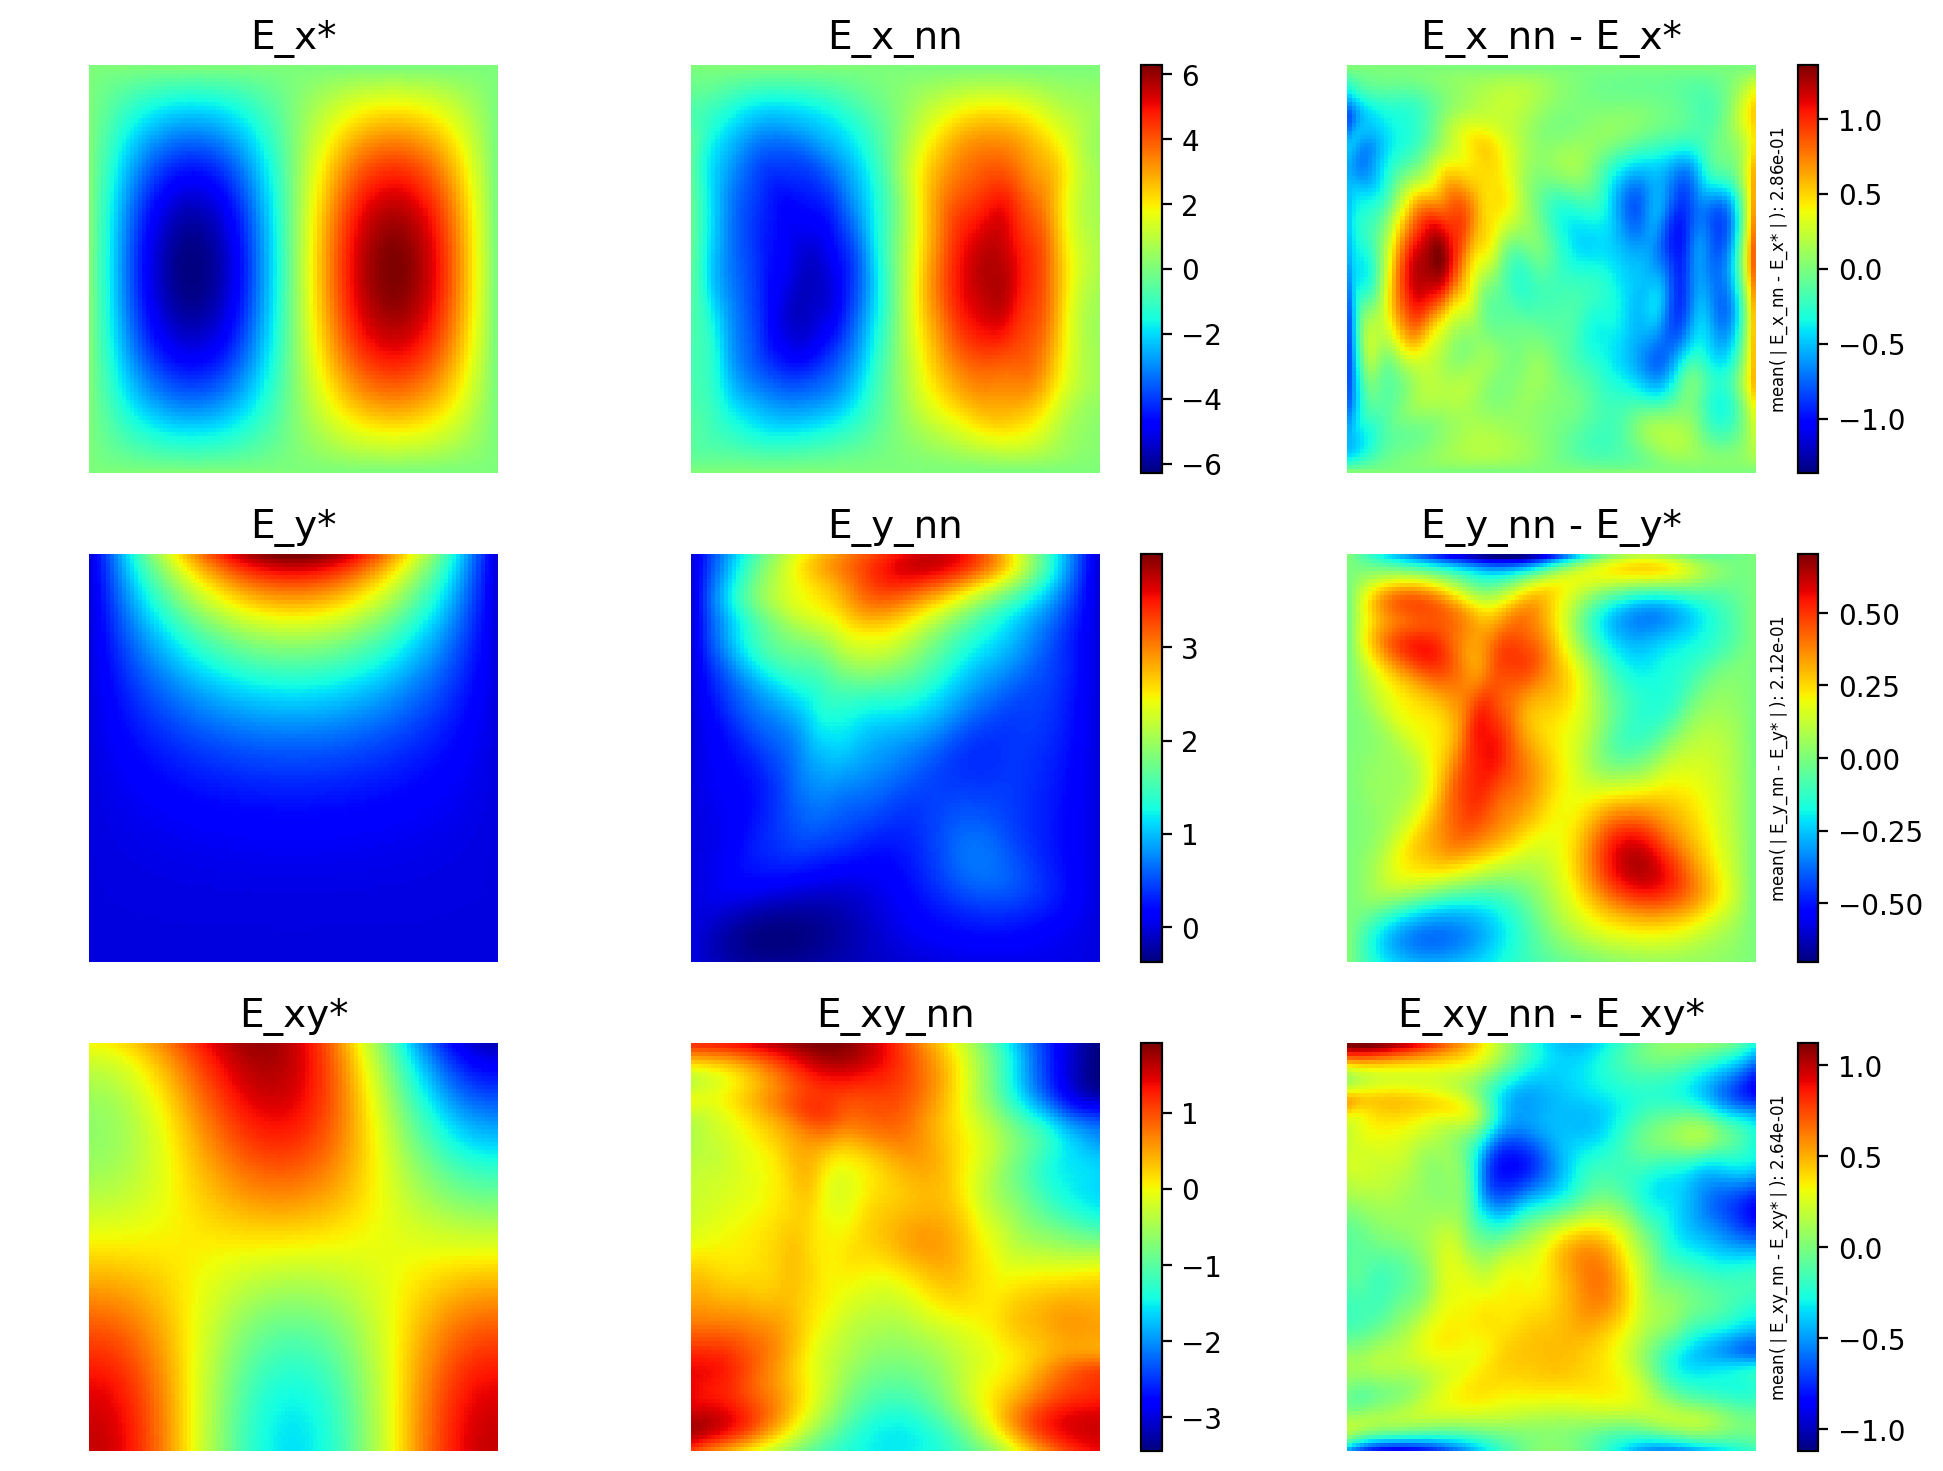

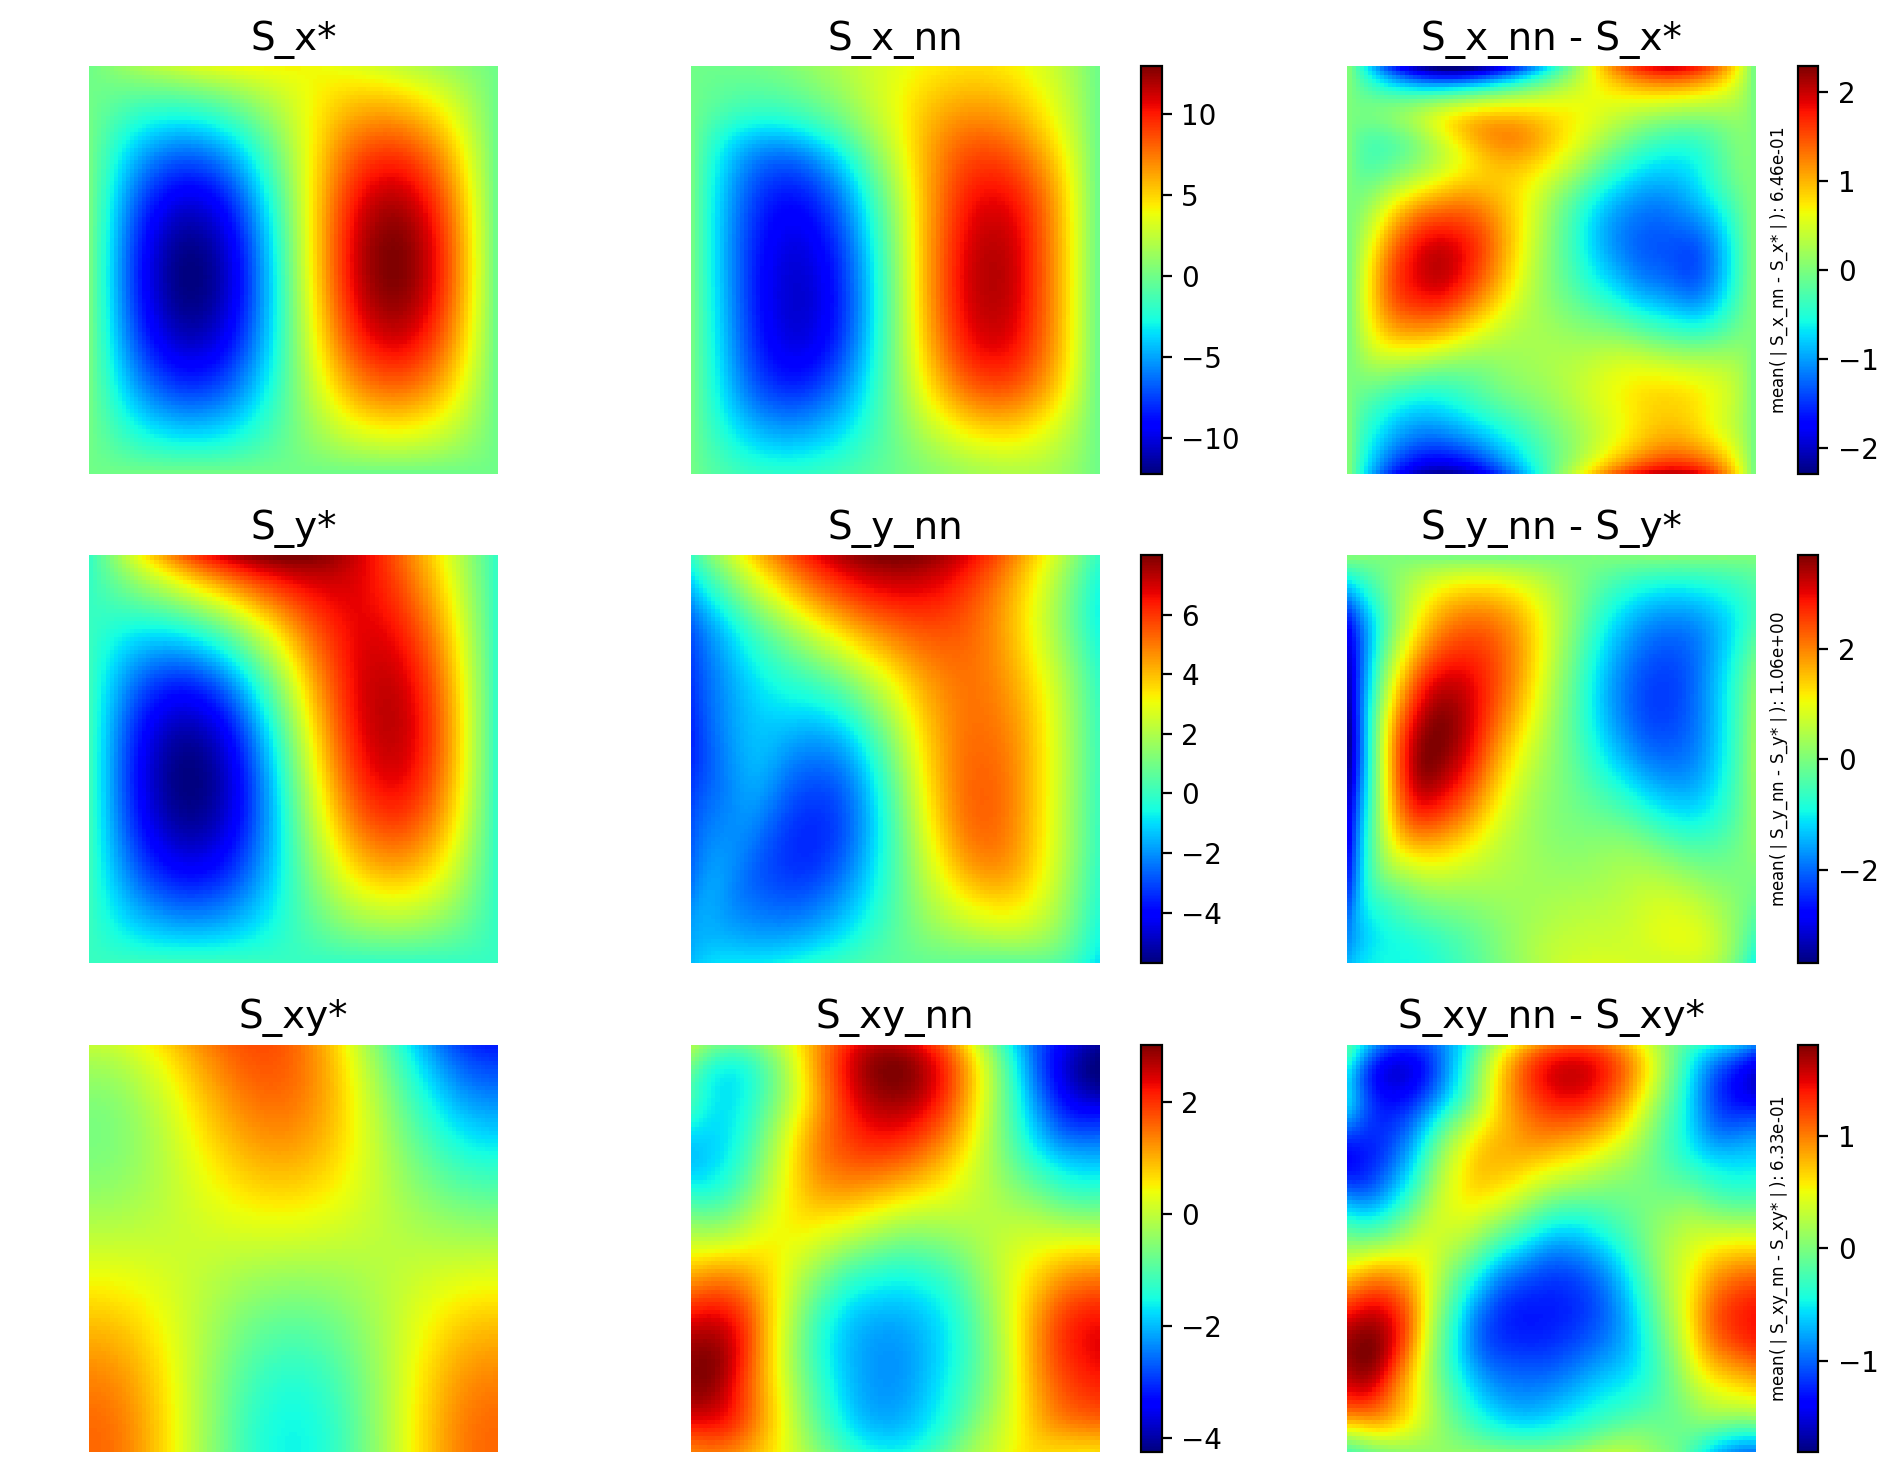

In [53]:
run_id = "1l1q5s6s"

model, config = load_model(run_id)

# Plotting the final solution

U_output = lambda x, ouput: (ouput[:,0], ouput[:,1]) 
S_output = lambda x, ouput: S_nn(E_nn(x,ouput)) if config['net_type'] == 'Unet' else (ouput[:,2], ouput[:,3], ouput[:,4]) 

U_field = bvp.plot_field(bvp.domain,model,output_func=U_output,V_exact=lambda x: (bvp.U_exact(x)[:,0], bvp.U_exact(x)[:,1]),plot_diff=True,fields_name="U")
E_field = bvp.plot_field(bvp.domain,model,output_func=bvp.E_nn,V_exact=bvp.E_exact,plot_diff=True)
S_field = bvp.plot_field(bvp.domain,model,output_func=S_output,V_exact=bvp.S_exact,plot_diff=True)